In [1]:
import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, vocs

evaluator = Evaluator(evaluate_TNK)
generator = BayesianExplorationGenerator(
    vocs, n_initial=2, proximal_lengthscales=[1.0,1.0]
)
print(vocs)
print(generator.options)
xopt_base = XoptBase(generator, evaluator, vocs)
xopt_base.step()

for i in range(40):
    print(f'step {i}')
    xopt_base.step()

variables={'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]} constraints={'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]} objectives={'y1': 'MINIMIZE', 'y2': 'MINIMIZE'} constants={'a': 'dummy_constant'} linked_variables=None
optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True) acq=AcqOptions(objective=ConstrainedMCObjective(), sampler=SobolQMCNormalSampler()) model=ModelOptions(input_transform=Normalize(), outcome_transform=Standardize()) tkwargs={'device': 'cpu', 'dtype': torch.float64} n_initial=2 proximal_lengthscales=[1.0, 1.0]
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39


In [2]:
xopt_base.history

,x1,x2,a,y1,y2,c1,c2,some_array,done,c1_feas,c2_feas,feas
0,0.214752,1.373731,dummy_constant,0.214752,1.373731,1.012228,0.844772,"[1, 2, 3]",True,True,False,False
1,0.723397,0.322770,dummy_constant,0.723397,0.322770,-0.463344,0.081316,"[1, 2, 3]",True,False,True,False
2,0.638820,0.574475,dummy_constant,0.638820,0.574475,-0.328057,0.024817,"[1, 2, 3]",True,False,True,False
3,0.679337,0.859330,dummy_constant,0.679337,0.859330,0.228773,0.161280,"[1, 2, 3]",True,True,True,True
4,0.744021,0.754036,dummy_constant,0.744021,0.754036,0.022708,0.124080,"[1, 2, 3]",True,True,True,True
5,0.741163,0.752634,dummy_constant,0.741163,0.752634,0.016534,0.121983,"[1, 2, 3]",True,True,True,True
6,0.896243,0.717705,dummy_constant,0.896243,0.717705,0.337432,0.204404,"[1, 2, 3]",True,True,True,True
7,0.625269,0.752476,dummy_constant,0.625269,0.752476,-0.052573,0.079436,"[1, 2, 3]",True,False,True,False
8,0.499040,0.738875,dummy_constant,0.499040,0.738875,-0.105340,0.057062,"[1, 2, 3]",True,False,True,False
9,0.295951,1.126992,dummy_constant,0.295951,1.126992,0.414452,0.434755,"[1, 2, 3]",True,True,True,True


<AxesSubplot:xlabel='x1'>

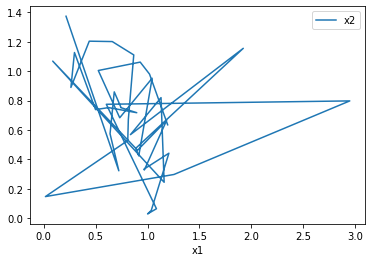

In [3]:
# plot results
xopt_base.history.plot("x1","x2")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


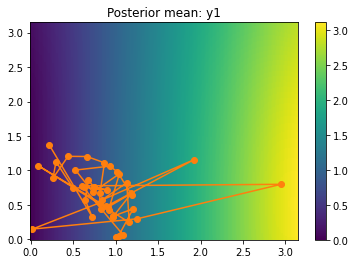

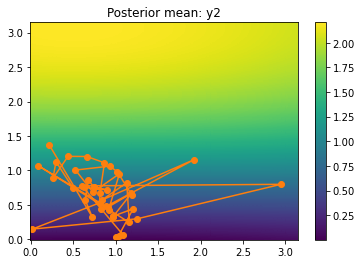

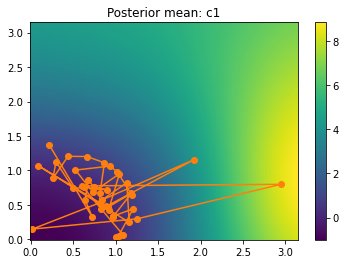

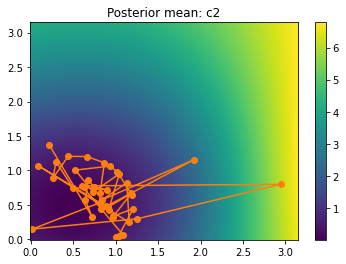

In [4]:
from matplotlib import pyplot as plt# plot model predictions
bounds = vocs.bounds
history = xopt_base.history

model = generator.get_model(history)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

outputs = list(vocs.objectives.keys()) + list(vocs.constraints.keys())
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig,ax = plt.subplots()
        ax.plot(*history[["x1","x2"]].to_numpy().T,'o-C1')
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n,n))
        fig.colorbar(c)
        ax.set_title(f'Posterior mean: {outputs[i]}')


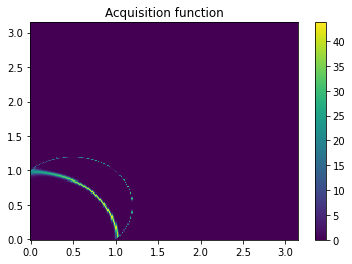

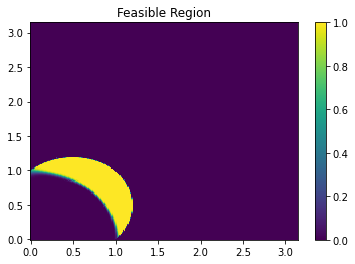

In [5]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        generator.options.acq.sampler,
        vocs
    ).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx,yy,feas.reshape(n,n))
    fig2.colorbar(c)
    ax2.set_title('Feasible Region')